In [7]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import sys

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
from datetime import datetime

import tensorflow as tf

if not os.path.exists('facenet'):
  !git clone https://github.com/davidsandberg/facenet --depth=1

sys.path.insert(0, './facenet/src')
import align.detect_face
import facenet
import scipy.spatial.distance as distance

In [8]:
# download pre-trained model at https://drive.google.com/open?id=0B5MzpY9kBtDVTGZjcWkzT3pldDA
model_dir = '/scratch/bagautdi/models/reid/20170216-091149/'

Cloning into 'facenet'...
remote: Counting objects: 87, done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 87 (delta 14), reused 27 (delta 0), pack-reused 0
Unpacking objects: 100% (87/87), done.
Checking connectivity... done.


In [9]:
# starting a session
tf.reset_default_graph()

tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_config.allow_soft_placement = True

sess = tf.Session(config=tf_config)

print('loading the detection/alignment network...')
pnet, rnet, onet = align.detect_face.create_mtcnn(sess, None)
print('done!')

print('loading the embedding network...')
meta_file, ckpt_file = facenet.get_model_filenames(model_dir)
restorer = tf.train.import_meta_graph(os.path.join(model_dir, meta_file))
restorer.restore(sess, os.path.join(model_dir, ckpt_file))
print('done!')

# getting input / output tensors
g = tf.get_default_graph()
images_in = g.get_tensor_by_name('input:0')
phase_train_in = g.get_tensor_by_name('phase_train:0')
embeddings = g.get_tensor_by_name('embeddings:0')


loading the detection/alignment network...
done!
loading the embedding network...
INFO:tensorflow:Restoring parameters from /scratch/bagautdi/models/reid/20170216-091149/model-20170216-091149.ckpt-250000
done!


In [4]:
# detection parameters
minsize = 20 
threshold = [ 0.6, 0.7, 0.7 ]
factor = 0.709

boxes = []
keypoints = []
images = []
print('detecting faces...')
for path in ['spain0000.jpg', 'spain0001.jpg']:
  img = scipy.misc.imread(path)
  img = scipy.misc.imresize(img, [img.shape[0]//4, img.shape[1]//4])
  bbs, kps = align.detect_face.detect_face(img, minsize, 
                                           pnet, rnet, onet, threshold, factor)
  kps = kps.reshape([2,5,-1]).T
  images.append(img)  
  boxes.append(bbs)
  keypoints.append(kps)
print('done!')  

detecting faces...
done!


In [5]:
print('computing embeddings')
size = 160
margin = 32

faces = []
faces_embs = []
for img, bbs in zip(images, boxes):
  img_faces = []
  for x0,y0,x1,y1,_ in bbs.astype(np.int32):
    x0 = np.maximum(x0 - margin//2, 0)
    y0 = np.maximum(y0 - margin//2, 0)
    x1 = np.minimum(x1 + margin//2, img.shape[1])
    y1 = np.minimum(y1 + margin//2, img.shape[0])
    img_faces.append(scipy.misc.imresize(img[y0:y1,x0:x1], (size, size)))
  img_faces = np.stack(img_faces)
  faces.append(img_faces)
  
  feed_dict = {
    images_in : img_faces.astype(np.float32) / 255.0,
    phase_train_in : False,
  }
  
  faces_embs.append(sess.run(embeddings, feed_dict))
print('done!')

computing embeddings
done!


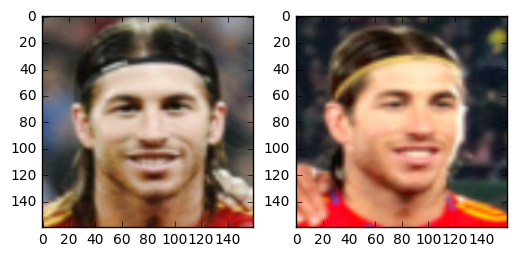

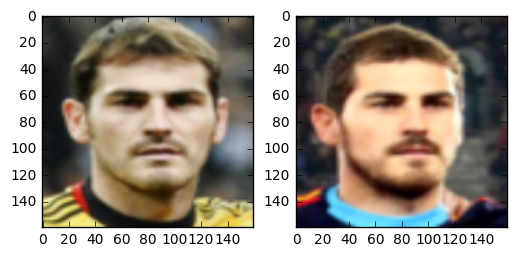

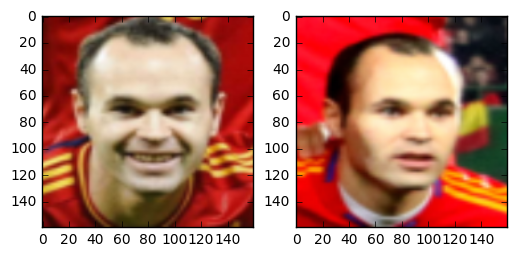

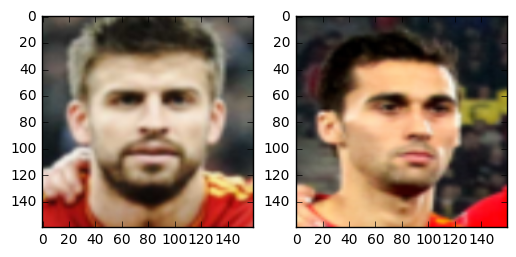

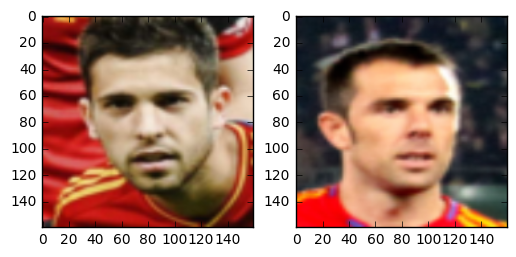

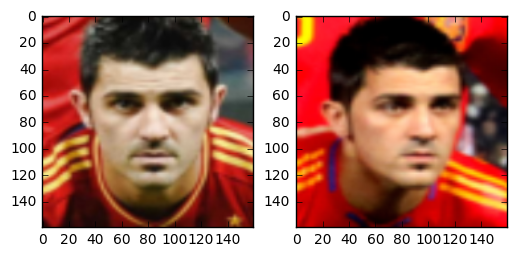

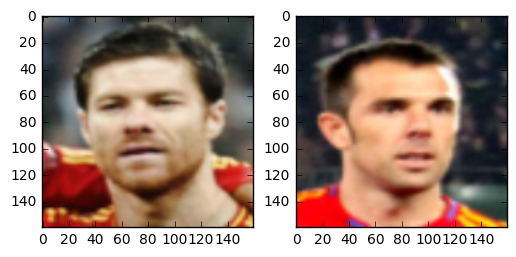

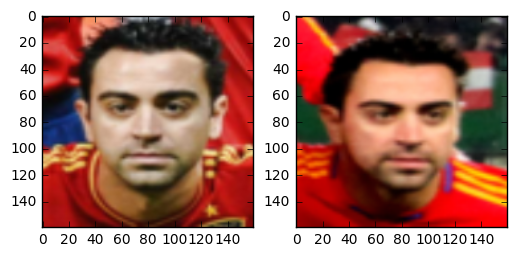

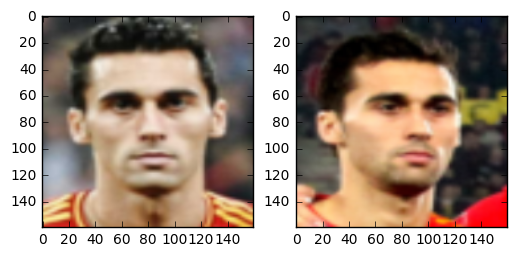

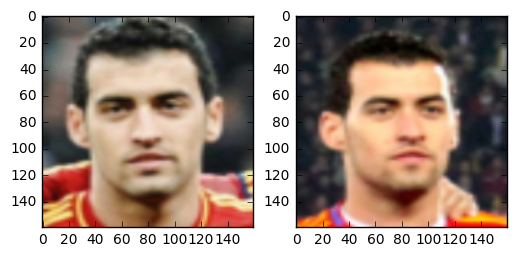

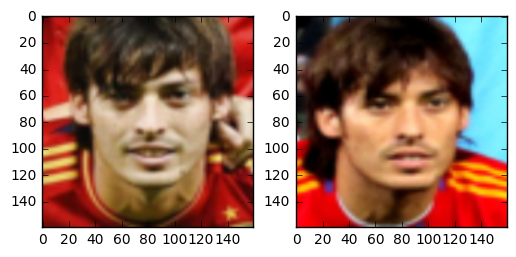

In [6]:
dist = distance.cdist(faces_embs[1], faces_embs[0])

for i in range(faces_embs[1].shape[0]):
  idx = np.argmin(dist[i])
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(faces[1][i])
  plt.subplot(1,2,2)
  plt.imshow(faces[0][idx])
#  print(i, idx)